<a href="https://colab.research.google.com/github/rawdhikagupta/Texture-Analysis-Model/blob/main/B_CNN_DTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# load dataset
path = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz'
path_to_file = tf.keras.utils.get_file("dtd-r1.0.1_data", path, archive_format = 'tar', untar = True, extract=True)

# extracted file is dtd/images in datasets dir
path_to_dir = "/root/.keras/datasets/dtd/images"

ds_train = tf.keras.utils.image_dataset_from_directory(
    path_to_dir, subset= 'training', validation_split = 0.3, seed = 42, shuffle = True, label_mode = 'int', batch_size=32, image_size=(448,448)
)


ds_test = tf.keras.utils.image_dataset_from_directory(
    path_to_dir, subset= 'validation', validation_split = 0.3, seed = 42, label_mode ='int', batch_size = 32, image_size=(448,448)
)



def pre_processing(image, label):
  image = tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

ds_train = ds_train.map(pre_processing, num_parallel_calls = tf.data.AUTOTUNE)
ds_test = ds_train.map(pre_processing, num_parallel_calls= tf.data.AUTOTUNE)

ds_train.prefetch(tf.data.AUTOTUNE)
ds_test.prefetch(tf.data.AUTOTUNE)

625254400/625239812 [==============================] - 46s 0us/step
Found 5640 files belonging to 47 classes.
Using 3948 files for training.
Found 5640 files belonging to 47 classes.
Using 1692 files for validation.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
basemodel_1 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
basemodel_1.trainable = False
basemodel_2 = tf.keras.applications.VGG19(include_top = False, weights ='imagenet')
basemodel_2.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
def B_CNN():
  inputs = tf.keras.Input(shape=[448, 448, 3])
  x = basemodel_1(inputs)

  model_1 = tf.keras.Model(inputs = inputs, outputs = x)

  z = model_1.output_shape
  #x = tf.keras.layers.Reshape([z[1]*z[2], z[-1]])(x)
  x = tf.keras.layers.Lambda(lambda x: tf.einsum('ijkm,ijkn->imn', x, x)/(z[1]*z[2]))(x)
  x = tf.keras.layers.Reshape([z[-1]*z[-1]])(x) # same as flatten
  x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sign(x)* tf.sqrt(tf.keras.backend.abs(x)+1e-9))(x)
  x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x))(x)
  
  #x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
  x = tf.keras.layers.Dense(47, activation ='softmax')(x)
  return tf.keras.Model(inputs=inputs, outputs = x)

In [ ]:
model = B_CNN()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 lambda_3 (Lambda)           (None, 512, 512)          0         
                                                                 
 reshape_1 (Reshape)         (None, 262144)            0         
                                                                 
 lambda_4 (Lambda)           (None, 262144)            0         
                                                                 
 lambda_5 (Lambda)           (None, 262144)            0         
                                                                 
 dense_1 (Dense)             (None, 47)                1232

In [ ]:

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['Accuracy'])
'''cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Datasets_PS/ck.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_freq=124)'''
history = model.fit(ds_train, epochs=25, validation_data=ds_test)

Epoch 1/25
124/124 [==============================] - 174s 1s/step - loss: 3.5978 - Accuracy: 0.2237 - val_loss: 3.3712 - val_Accuracy: 0.4534
Epoch 2/25
124/124 [==============================] - 174s 1s/step - loss: 3.1374 - Accuracy: 0.5332 - val_loss: 3.0239 - val_Accuracy: 0.5550
Epoch 3/25
124/124 [==============================] - 176s 1s/step - loss: 2.7853 - Accuracy: 0.6170 - val_loss: 2.7523 - val_Accuracy: 0.5854
Epoch 4/25
124/124 [==============================] - 175s 1s/step - loss: 2.5149 - Accuracy: 0.6532 - val_loss: 2.5415 - val_Accuracy: 0.6026
Epoch 5/25
124/124 [==============================] - 175s 1s/step - loss: 2.3022 - Accuracy: 0.6826 - val_loss: 2.3740 - val_Accuracy: 0.6175
Epoch 6/25
124/124 [==============================] - 176s 1s/step - loss: 2.1289 - Accuracy: 0.6991 - val_loss: 2.2353 - val_Accuracy: 0.6297
Epoch 7/25
124/124 [==============================] - 175s 1s/step - loss: 1.9838 - Accuracy: 0.7150 - val_loss: 2.1224 - val_Accuracy: 0.6363

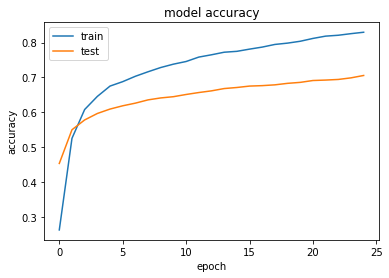

In [ ]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()